# Post Processing of MaxQuant output (proteinGroups.txt)

## Import Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
default_graph_dimensions = (10, 6)

In [3]:
"""
Input: Path to tab separated file
Output: Pandas dataframe
"""

def load_data(file):
    df = pd.read_csv(file, sep='\t', lineterminator='\r', dtype={"Only identified by site": str, "Reverse": str})
    return df

datafile="D:\proteinGroupsCleaned.txt"  # From Geremy
#datafile="D:\proteinGroups.txt" # My file

df = load_data(datafile)
print(df.head())

     Protein IDs Majority protein IDs Peptide counts (all)  \
0  \n1433B_MOUSE          1433B_MOUSE                   25   
1  \n1433E_MOUSE          1433E_MOUSE                   27   
2  \n1433F_MOUSE          1433F_MOUSE                   28   
3  \n1433G_MOUSE          1433G_MOUSE                   23   
4  \n1433S_MOUSE          1433S_MOUSE                   13   

  Peptide counts (razor+unique) Peptide counts (unique)  \
0                            18                      16   
1                            25                      25   
2                            25                      24   
3                            17                      17   
4                            11                      11   

                                       Fasta headers  Number of proteins  \
0  >1433B_MOUSE 14-3-3 protein beta/alpha; AltNam...                 1.0   
1  >1433E_MOUSE 14-3-3 protein epsilon; Short=14-...                 1.0   
2  >1433F_MOUSE 14-3-3 protein eta; Accessio

## Clean Data
* Remove rows corresponding to the proteins only identified by site/Reverse/Potential contaminant
* Remove rows with multiple protein IDs
* Extract separately the LFQ and the iBAQ quantification info


In [4]:
def remove_weakly_identified(df):
    df = df[(df['Only identified by site'] != '+') & (df.Reverse != '+') & (df['Potential contaminant'] != '+')]
    return df
    
print("Before:", len(df[df['Only identified by site'] == '+']), len(df[df['Reverse'] == '+']), len(df[df['Potential contaminant'] == '+']))

df = remove_weakly_identified(df)

print("After:", len(df[df['Only identified by site'] == '+']), len(df[df['Reverse'] == '+']), len(df[df['Potential contaminant'] == '+']))

Before: 13 64 21
After: 0 0 0


In [5]:
"""
Input: Dataframe
Output: Dataframe where rows with multiple proteinIDs have been removed
"""
def remove_dup_proteinIDs(df):
    single_proteinID = df['Majority protein IDs'].str.contains(';')==False
    df = df[single_proteinID]
    return df

print("Before:", len(df[df['Majority protein IDs'].str.contains(';', na=False)]))

df = remove_dup_proteinIDs(df)

print("After:", len(df[df['Majority protein IDs'].str.contains(';', na=False)]))

Before: 71
After: 0


In [6]:
### TODO: 'Majority protein IDs' hard coded. Column name for iBAQ must include space to exclude "iBAQ" column

"""
Input: Original dataframe
Output: Dataframe slice containing quant info for the specified columns
"""
def slice_by_column(df, col_name):
    selected_columns = col_name + '.*|Majority protein IDs'
    df_slice = df.filter(regex=(selected_columns))
    return df_slice

### Take separate df slices for different quant techniques

LFQ_df = slice_by_column(df, 'LFQ')
print("***** LFQ_df:\n", LFQ_df.head())

iBAQ_df = slice_by_column(df, 'iBAQ ')
print("\n***** iBAQ_df:\n", iBAQ_df.head())

***** LFQ_df:
   Majority protein IDs  LFQ intensity 04_Liver  LFQ intensity 05_Liver  \
0          1433B_MOUSE            2.093000e+09            1.998200e+09   
1          1433E_MOUSE            3.903200e+09            4.020100e+09   
2          1433F_MOUSE            7.336300e+08            8.709900e+08   
3          1433G_MOUSE            2.660800e+09            2.614600e+09   
4          1433S_MOUSE            0.000000e+00            1.399700e+09   

   LFQ intensity 06_Liver  LFQ intensity 07_Brain  LFQ intensity 07_Heart  \
0            2.184700e+09            1.371400e+10            1.790900e+09   
1            3.902000e+09            1.655000e+10            5.943600e+09   
2            9.208000e+08            9.259900e+09            1.254300e+09   
3            3.038100e+09            2.334300e+10            3.877100e+09   
4            1.961200e+09            7.550100e+09            0.000000e+00   

   LFQ intensity 07_Kidney  LFQ intensity 07_Liver  LFQ intensity 07_Lung  \


## Normalize
### For both LFQ and iBAQ:
* Consider only the proteins observed at least in 50 percent of the sample for at least one organ for quantification
* log2 normalize
* Median normalize: the median of the log2(LFQ or IBAQ) of each protein in a given sample is used to normalize all the protein abundance of this sample, then multiply all the resulting values by the median of the medians
* Impute the missing values: the minimum of the resulting table divided by 2


In [7]:
#########################
#
# Filter out proteins where quant value is 0 for >= 50% of samples for all organs
#
#########################

num_mice = 6
threshold = num_mice/2

print(iBAQ_df.shape)

# Group by organ
iBAQ_cols = iBAQ_df.columns.values.tolist()
organs = ['Liver', 'Kidney', 'Lung', 'Brain', 'Heart']
organ_columns = {} # 'liver': ['iBAQ 04_Liver', 'iBAQ 05_Liver', ...]
column_to_group = {} # 'iBAQ 04_liver' : 'liver'
organ_counts = {} # 'liver': 

# Create list of column names corresponding to each organ
for organ in organs:
    regex = re.compile(r'.*' + organ)
    org = organ.lower()
    organ_columns[org] = list(filter(regex.search, iBAQ_cols))
    cols = organ_columns[org] # Get corresponding list of column names
    organ_counts[org] = (iBAQ_df[cols] > 0).sum(1) # count number of samples with non-zero abundance for each protein
    for col in cols: # Fill in dict mapping column name to group
        column_to_group[col] = org 

iBAQ_df = iBAQ_df[(organ_counts['liver'] >= threshold) | (organ_counts['lung'] >= threshold) | (organ_counts['heart'] >= threshold) | (organ_counts['kidney'] >= threshold) | (organ_counts['brain'] >= threshold)]
    
print(iBAQ_df.shape)

(5530, 31)
(5498, 31)


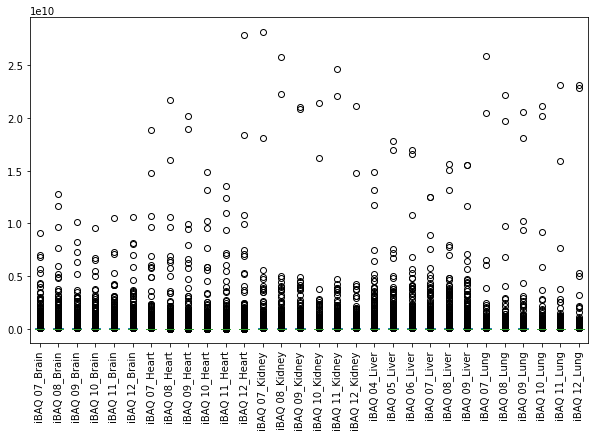

In [8]:
#########################
#
# Unnormalized data abundances 
#
#########################

# Group columns by organ so x-axis will be sorted accordingly
iBAQ_df = iBAQ_df[['Majority protein IDs'] + organ_columns['brain'] + organ_columns['heart'] + organ_columns['kidney'] + organ_columns['liver'] + organ_columns['lung']]

iBAQ_df.plot(kind='box', return_type='axes', figsize=(10,6))
plt.xticks(rotation='vertical')

plt.savefig(r'D:\Images\unnormalized_abundances.pdf', bbox_inches="tight")
plt.show()

In [9]:
#########################
#
# log2 normalize
#
#########################

iBAQ_df.iloc[:,1:] = iBAQ_df.iloc[:,1:].applymap(np.log2)

print(iBAQ_df.head())

# log2(0) returns -inf; replace with NaN to avoid skewing data
iBAQ_df.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4451: RuntimeWarning: divide by zero encountered in log2
  return lib.map_infer(x.asobject, func)


  Majority protein IDs  iBAQ 07_Brain  iBAQ 08_Brain  iBAQ 09_Brain  \
0          1433B_MOUSE      29.897295      29.850685      29.509337   
1          1433E_MOUSE      29.804751      30.438967      29.688125   
2          1433F_MOUSE      29.412036      29.154532      29.276819   
3          1433G_MOUSE      30.647616      30.379375      30.266065   
4          1433S_MOUSE      28.918036      28.992751      28.983974   

   iBAQ 10_Brain  iBAQ 11_Brain  iBAQ 12_Brain  iBAQ 07_Heart  iBAQ 08_Heart  \
0      29.094665      29.821559      29.712026      25.702398      25.617593   
1      29.719928      30.074697      30.296907      27.074799      26.930328   
2      29.065045      29.366822      29.403995      24.583883      24.376236   
3      30.238656      30.261477      30.357938      26.637961      26.518558   
4      28.582441      28.746568      28.906213      25.333199      25.168826   

   iBAQ 09_Heart      ...       iBAQ 06_Liver  iBAQ 07_Liver  iBAQ 08_Liver  \
0      25.876

In [10]:
#########################
#
# Map organs to colors for visualization clarity 
#
#########################

color_dict = {} # Column name : color
num_colors = 6
colors = sns.color_palette("hls", num_colors)
color = 0

for organ in organs:
    cols = organ_columns[organ.lower()] # Get the list of column names for the organ
    for col in cols:
        color_dict[col] = colors[color % len(colors)]
    color += 1

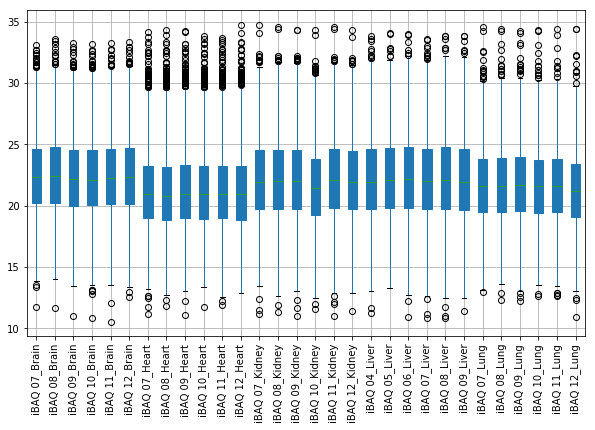

In [11]:
#########################
#
# log2 transformed distribution 
#
#########################

iBAQ_df.boxplot(return_type='axes', figsize=(10,6), patch_artist = True)

#c=[color_dict.get(x, 'gray') for x in iBAQ_df.columns[1:]])

#for col in iBAQ_df.columns[1:]:
#    plt.setp(bp['boxes'], color = color_dict[col])

plt.xticks(rotation='vertical')

plt.show()

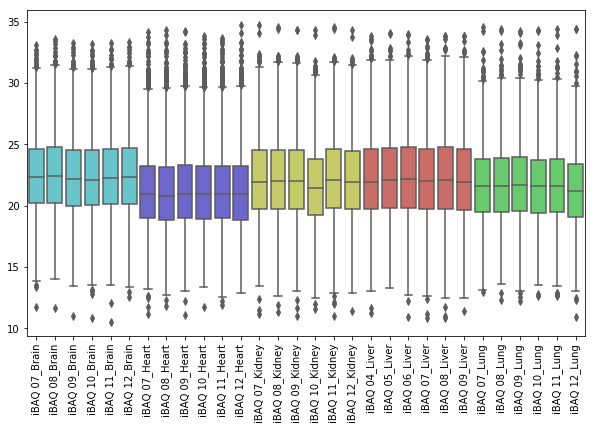

In [12]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
sns.boxplot(data=iBAQ_df, palette=color_dict, ax=ax)

plt.savefig(r'D:\Images\log2_transformed_boxplots.pdf', bbox_inches="tight")
plt.show()

In [13]:
#########################
#
# Median normalize
#
#########################

iBAQ_quants = iBAQ_df.iloc[:,1:] # Split off iBAQ columns to process
iBAQ_median_of_medians = iBAQ_quants.median().median()

iBAQ_quants /= iBAQ_quants.median(axis=0) # divide each value by sample median
iBAQ_quants *= iBAQ_median_of_medians # multiply each value by median of medians

iBAQ_df.iloc[:,1:] = iBAQ_quants # insert processed iBAQ values into original df
print(iBAQ_df.head())

  Majority protein IDs  iBAQ 07_Brain  iBAQ 08_Brain  iBAQ 09_Brain  \
0          1433B_MOUSE      29.381916      29.224766      29.202234   
1          1433E_MOUSE      29.290967      29.800712      29.379161   
2          1433F_MOUSE      28.905022      28.543210      28.972135   
3          1433G_MOUSE      30.119303      29.742370      29.951087   
4          1433S_MOUSE      28.419538      28.384821      28.682338   

   iBAQ 10_Brain  iBAQ 11_Brain  iBAQ 12_Brain  iBAQ 07_Heart  iBAQ 08_Heart  \
0      28.866554      29.381840      29.233520      26.925319      27.069953   
1      29.486915      29.631245      29.808981      28.363019      28.457112   
2      28.837166      28.933808      28.930450      25.753586      25.758219   
3      30.001576      29.815271      29.869030      27.905397      28.021998   
4      28.358346      28.322699      28.440684      26.538554      26.595744   

   iBAQ 09_Heart      ...       iBAQ 06_Liver  iBAQ 07_Liver  iBAQ 08_Liver  \
0      27.099

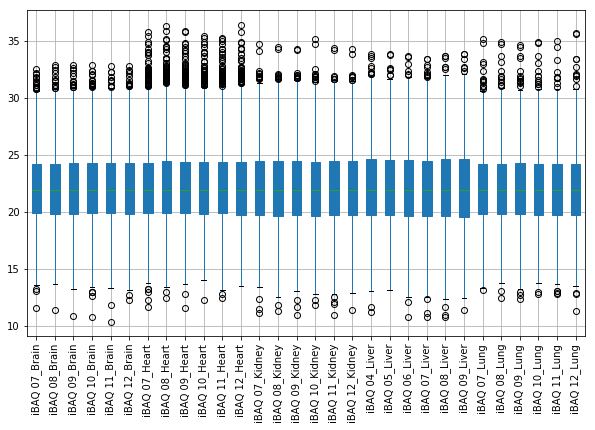

In [14]:
#########################
#
# Median normalized log2 data distribution 
#
#########################

iBAQ_df.boxplot(return_type='axes', figsize=(10,6), patch_artist = True)
plt.xticks(rotation='vertical')
plt.show()

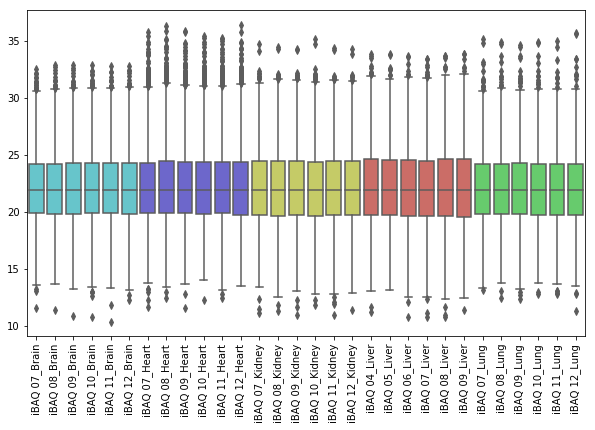

In [15]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
sns.boxplot(data=iBAQ_df, palette=color_dict, ax=ax)

plt.savefig(r'D:\Images\median_normalized_boxplots.pdf', bbox_inches="tight")
plt.show()

In [16]:
#########################
#
# Impute missing values
#
#########################

print(iBAQ_df.isnull().values.any()) # Should return true if any nulls are present

iBAQ_min = iBAQ_quants.min().min()
iBAQ_impute_val = iBAQ_min/2

iBAQ_df = iBAQ_df.fillna(iBAQ_impute_val)

print(iBAQ_df.isnull().values.any()) # Should return false if nulls have been replaced

True
False


## PCA

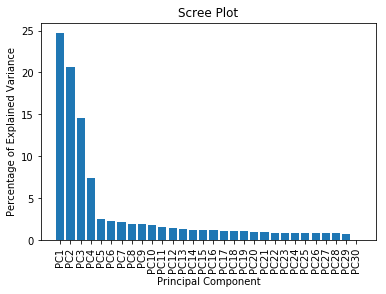

In [17]:
#########################
#
# Perform PCA on the data
#
#########################

iBAQ_df.set_index('Majority protein IDs', inplace=True)
scaled_data = preprocessing.scale(iBAQ_df.T)

pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for dataframe
 
#########################
#
# Draw a scree plot 
#
#########################
 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals = 1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x = range(1, len(per_var) + 1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.xticks(rotation='vertical')

plt.savefig(r'D:\Images\PCA_scree.pdf', bbox_inches="tight")
plt.show()


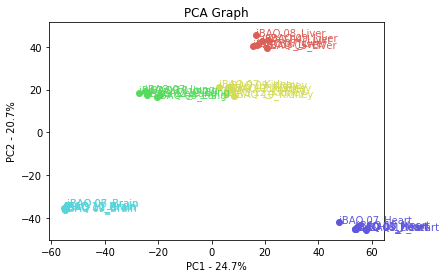

In [18]:
#########################
#
# Draw PCA Graph 
#
#########################

pca_df = pd.DataFrame(pca_data, index=[iBAQ_df.columns.values.tolist()], columns=labels)
 
plt.title('PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
for column in pca_df.index:
    plt.scatter(pca_df.PC1.loc[column], pca_df.PC2.loc[column], color = color_dict[column])
    plt.annotate(column, (pca_df.PC1.loc[column], pca_df.PC2.loc[column]), color = color_dict[column])

plt.savefig(r'D:\Images\PCA_Graph.pdf', bbox_inches="tight")
plt.show()

In [19]:
#########################
#
# Determine which proteins had the biggest influence on PC1 
#
#########################

loading_scores = pd.Series(pca.components_[0], index=iBAQ_df.index)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_10_proteins = sorted_loading_scores[0:10].index.values
print(loading_scores[top_10_proteins])

Majority protein IDs
DECR_MOUSE     0.026859
ECI1_MOUSE     0.026836
ECH1_MOUSE     0.026826
ETFB_MOUSE     0.026683
PURB_MOUSE    -0.026510
CPT2_MOUSE     0.026398
CAND1_MOUSE   -0.026382
ECHM_MOUSE     0.026367
ACADV_MOUSE    0.026333
1433Z_MOUSE   -0.026293
dtype: float64


## Heatmaps
* Pearson Correlations
* Hierarchical Clustering

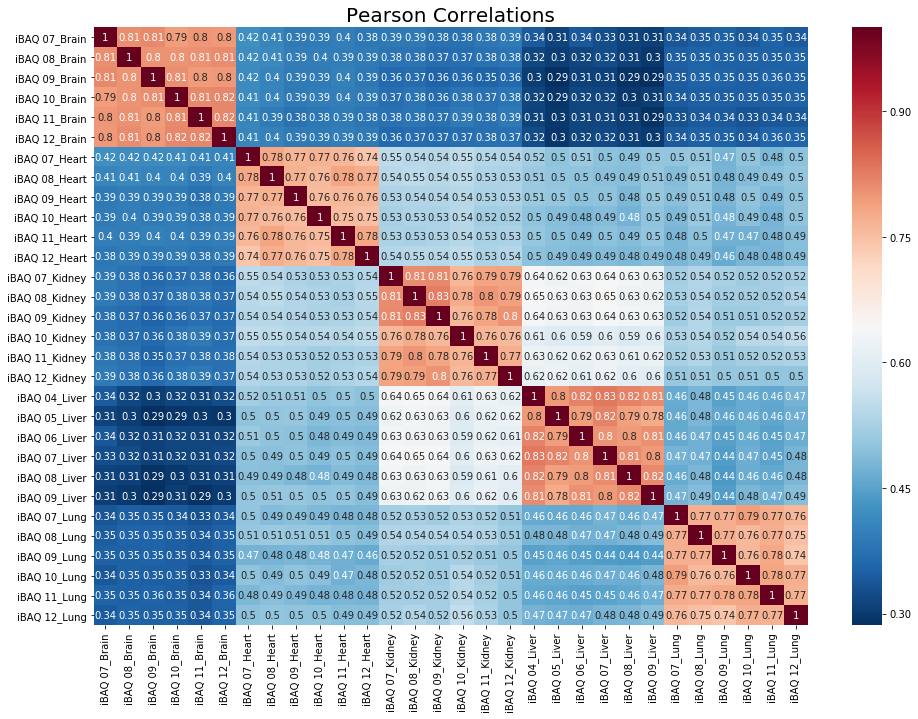

In [20]:
#########################
#
# Pearson correlation of the samples compared to each other 
#
#########################

fig, ax = plt.subplots(figsize = (16, 11))
ax.set_title('Pearson Correlations', size = 20)

corr = iBAQ_df.corr(method = 'pearson')
sns.heatmap(corr, 
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,
            annot = True, # Show numerical values in each box
            cmap = "RdBu_r", 
            ax = ax) 

plt.savefig(r'D:\Images\Pearson_Corr.pdf', bbox_inches="tight")
plt.show()

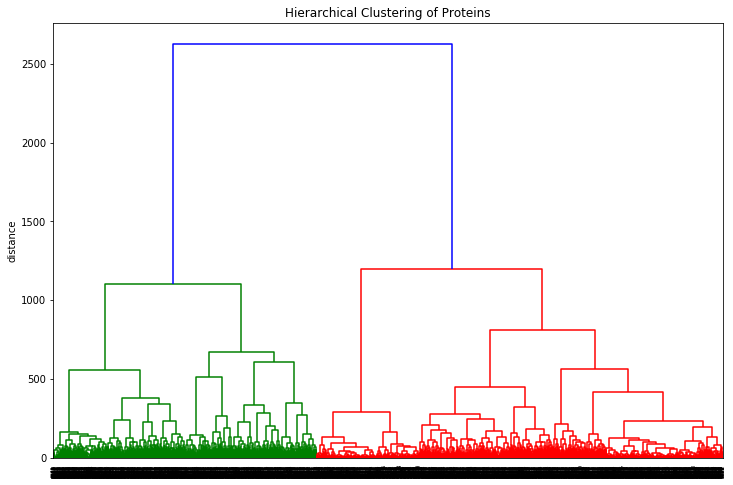

In [21]:
#########################
#
# Hierarchical clustering of proteins
#
#########################

z = linkage(iBAQ_df.values, method='ward')

plt.figure(figsize=(12, 8))
plt.title('Hierarchical Clustering of Proteins')
plt.ylabel('distance')
dendrogram(z,
           leaf_rotation=90.,  # rotates the x axis labels
           #leaf_font_size=8.,  # font size for the x axis labels
          )

plt.savefig(r'D:\Images\Protein_Hierarchical_Clustering.pdf', bbox_inches="tight")
plt.show()


## ANOVA and t-tests

In [22]:
print(len(iBAQ_df))

# Build list of proteins that pass ANOVA
pass_anova = []
max_pval = .05

proteins = list(iBAQ_df.index)

# Perform ANOVA on each row (protein) grouping by organ
# If the protein passes ANOVA (p-value <= .05), add it to the list of proteins to keep

for i in range(len(iBAQ_df)): 
    f, p = stats.f_oneway(iBAQ_df.iloc[i, :6],
                          iBAQ_df.iloc[i, 6:12],
                          iBAQ_df.iloc[i, 12:18], 
                          iBAQ_df.iloc[i, 18:24], 
                          iBAQ_df.iloc[i, 24:30])
    if p <= max_pval:
        pass_anova.append(proteins[i])

#f, p = stats.f_oneway(iBAQ_df.iloc[0, :2], iBAQ_df.iloc[0, 2:4], iBAQ_df.iloc[0, 4:6]) # Should not pass
#f, p = stats.f_oneway(iBAQ_df.iloc[10, :6], iBAQ_df.iloc[10, 6:12], iBAQ_df.iloc[10, 12:18], iBAQ_df.iloc[10, 18:24], iBAQ_df.iloc[10, 24:30])
#print('F value:', f)
#print('P value:', p)

# Filter dataframe down to only include proteins in pass_anova
pass_anova_df = iBAQ_df[iBAQ_df.index.isin(pass_anova)]

# Sanity check that the dataframe got filtered
print(len(pass_anova))
print(len(pass_anova_df))

5498
5138
5138


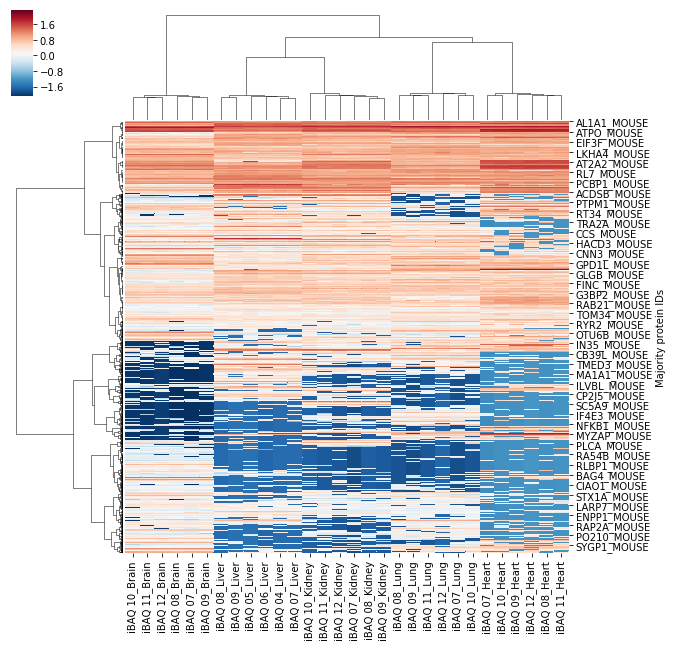

In [23]:
#########################
#
# Heatmap of proteins passing ANOVA with <= .05 p-value
#
#########################

sns.clustermap(pass_anova_df,
               method = 'ward',
               z_score = 1, # on columns
               cmap = "RdBu_r")

plt.savefig(r'D:\Images\Protein_Passing_ANOVA_Heatmap.pdf', bbox_inches="tight")
plt.show()

In [24]:
# Make array of groups corresponding to array of column names
# e.g. 'iBAQ 07_Brain' and 'iBAQ 08_Brain' both correspond to the group 'brain'

print(pass_anova_df.iloc[0, :])

groups = []
for col in pass_anova_df.columns.values:
    groups.append(column_to_group[col])
    
print(groups)

iBAQ 07_Brain     29.381916
iBAQ 08_Brain     29.224766
iBAQ 09_Brain     29.202234
iBAQ 10_Brain     28.866554
iBAQ 11_Brain     29.381840
iBAQ 12_Brain     29.233520
iBAQ 07_Heart     26.925319
iBAQ 08_Heart     27.069953
iBAQ 09_Heart     27.099760
iBAQ 10_Heart     26.504151
iBAQ 11_Heart     26.730698
iBAQ 12_Heart     26.879913
iBAQ 07_Kidney    27.576695
iBAQ 08_Kidney    27.373524
iBAQ 09_Kidney    27.259998
iBAQ 10_Kidney    27.354436
iBAQ 11_Kidney    27.414531
iBAQ 12_Kidney    27.053408
iBAQ 04_Liver     26.560774
iBAQ 05_Liver     26.546595
iBAQ 06_Liver     26.956463
iBAQ 07_Liver     25.979800
iBAQ 08_Liver     26.694899
iBAQ 09_Liver     26.547403
iBAQ 07_Lung      28.743844
iBAQ 08_Lung      28.724148
iBAQ 09_Lung      28.714149
iBAQ 10_Lung      28.560962
iBAQ 11_Lung      28.556606
iBAQ 12_Lung      28.509700
Name: 1433B_MOUSE, dtype: float64
['brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'heart', 'heart', 'heart', 'heart', 'heart', 'heart', 'kidney', 'kidney

In [25]:
#########################
#
# Tukey Testing 
#
#########################

# tukeys[i] == tukey results for protein in pass_anova_df row i
tukeys = []

# Build up list of tukey results
for i in range(len(pass_anova_df)): 
    tukey = pairwise_tukeyhsd(endog = pass_anova_df.iloc[i, :], # Row of data
                              groups = groups, # Groups
                              alpha = 0.05) # Significance level
    tukeys.append(tukey)
    
# Build up list of tuples corresponding to all organ pairs in order of testing
all_groups = tukeys[0].groupsunique
group_pairs = []

for i in range(len(all_groups) - 1):
    for j in range (i + 1, len(all_groups)):
        pair = (all_groups[i], all_groups[j])
        group_pairs.append(pair)
    

# For each comparison, keep track of which organs have always passed t-test
# For those always passing, build up list of meandiffs observed

def group_to_meandiffs(pairs, protein, enhanced_in, mean_diffs):
    
    diffs = {} # 'brain' : [-2.34, -1.87, ...]

    for i in range(len(pairs)):
        g1 = pairs[i][0]
        g2 = pairs[i][1]
        if tukeys[protein].reject[i] == False:
            if g1 in enhanced_in:
                enhanced_in.remove(g1)
            if g2 in enhanced_in:
                enhanced_in.remove(g2)
        else:
            if g1 in diffs:
                diffs[g1].append(mean_diffs[i])
            else:
                diffs[g1] = [mean_diffs[i]]
            if g2 in diffs:
                diffs[g2].append(mean_diffs[i])
            else:
                diffs[g2] = [mean_diffs[i]]
                
    return diffs
    

In [26]:
# If we want to get the top n proteins enriched for an organ:
# dict: {organ : list of (protein, meandiff) tuples}
# {'brain' : [(1433B_Mouse, 1.8677), (4341Z_Mouse, 2.56)]}
# Get value for organ, sort by tuple[1] descending, return first n elements in list
  
# Initialize all groups with empty list
enriched_dict = {}
for group in all_groups:
    enriched_dict[group] = []

### Loop through all proteins
for i in range(len(pass_anova_df)): 
    mean_diffs = tukeys[i].meandiffs
    enhanced_in = tukeys[i].groupsunique.tolist()
    
    diffs = group_to_meandiffs(group_pairs, i, enhanced_in, mean_diffs)
    for key in diffs.keys():
        diffs[key] = np.mean(np.fabs(diffs[key]))
    
    for organ in enhanced_in:
        tuple = (pass_anova_df.index.values.tolist()[i], diffs[organ])
        enriched_dict[organ].append(tuple)   

# Get top n enriched proteins for organ
def getSecond(tuple):
    return tuple[1]

def top_n_enriched(n, organ):
    all_proteins = enriched_dict[organ]
    all_proteins_sorted = sorted(all_proteins, key = getSecond, reverse = True)
    return all_proteins_sorted[:n]

print(top_n_enriched(5, 'brain'))

[('CLD11_MOUSE', 23.028525974365795), ('VATG2_MOUSE', 21.096408518374854), ('MT3_MOUSE', 20.937192161470136), ('FXYD7_MOUSE', 20.756758590462795), ('CADM2_MOUSE', 20.524681329097842)]


## TODO 
* Tuckey test
* Dynamically determine column indices for organ groups, size of groups
* Take argument to choose iBAQ or LFQ. Or generate stats for both
* Write images out to file - take arguments for base directory and specific dataset name